In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch.nn.functional as f

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Aug 25 09:11:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
path = "drive/My Drive/Colab Notebooks/data/Datasets_Healthy_Older_People/S1_Dataset"
files = os.listdir(path)
gender_list = []
for i in range(len(files)):
    gender_list.append(files[i][-1])
dataset = []
for i in range(len(files)):
    lines = []
    file_path = path + "/" + files[i]
    file = open(file_path, "r")
    while True:
        every_line = file.readline()
        if not every_line:
            break
        every_line = every_line.strip().split(",")
        every_line.insert(-1, (1. if gender_list[i] is "M" else 0.))
        lines = [float(x) for x in every_line]
        dataset.append(lines)
values = []
classes = []
for i in range(len(dataset)):
    values.append(dataset[i][0:-1])
    classes.append(int(dataset[i][-1])-1)
data = {
    "value": values,
    "class": classes
}
data_df = pd.DataFrame(data, columns=["value", "class"])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data
print(len(data_df))
data_df.head()

75128


,value,class
0,"[72.55, 0.98728, 0.46851, -0.047893, 1.0, -58....",0
1,"[271.32, 0.27203, 0.3422, -1.0057, 3.0, -61.5,...",2
2,"[144.88, 0.43619, 0.92784, 0.11175, 1.0, -60.5...",0
3,"[22.35, 0.9521, 0.14698, -0.12771, 4.0, -64.5,...",2
4,"[753.83, 0.22513, 0.98526, 0.031928, 1.0, -49....",3


In [ ]:
values_min = np.amin(np.array(values), axis=0)
values_ptp = np.ptp(np.array(values), axis=0)
print(values_min.tolist())
print(values_ptp.tolist())

[0.0, -0.74808, -0.55349, -1.3364, 1.0, -72.0, 0.0, 920.25, 0.0]
[1739.4, 2.25128, 2.58369, 2.5542, 3.0, 33.5, 6.2817, 5.5, 1.0]


In [ ]:
class DHOP(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        arr_value = np.array(list(self.df["value"]))
        # x = self.Normalization(arr_value)[index]
        x = arr_value[index]
        y = np.array(list(self.df["class"]))[index]
        return x, y
    def Normalization(self, arr):
        min = np.amin(arr, axis=0)
        ptp = np.ptp(arr, axis=0)
        arr = np.subtract(arr, min)
        arr = np.divide(arr, ptp)
        return arr

In [ ]:
train_split = 0.7
valid_split = 0.1

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

DHOP_dataset_train = DHOP(df = data_df[:train_size])
DHOP_dataset_valid = DHOP(df = data_df[train_size:train_size + valid_size])
DHOP_dataset_test = DHOP(df = data_df[train_size + valid_size:])

In [ ]:
train_loader = torch.utils.data.DataLoader(
      DHOP_dataset_train,
      batch_size = 20,
      shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
      DHOP_dataset_valid,
      batch_size = 20,
      shuffle = True
)
test_loader = torch.utils.data.DataLoader(
      DHOP_dataset_test,
      batch_size = 20,
      shuffle = True
)

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.layer1 = nn.Sequential(
              nn.Conv1d(1, 3, 3, padding=1),
              nn.ReLU()
        )
        self.layer2 = nn.Sequential(
              nn.Conv1d(3, 5, 3, padding=1),
              nn.ReLU()
        )
        self.layer3 = nn.MaxPool1d(2)
        self.layer4 = nn.Sequential(
              nn.Conv1d(5, 7, 3, padding=1),
              nn.ReLU()
        )
        self.layer5 = nn.Linear(28, 4)
    def forward(self, input):
        out = input.unsqueeze(1)
        # print(out.shape)
        out = self.layer1(out)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # print(out.shape)
        out = self.layer4(out)
        # print(out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.layer5(out)
        return out

In [ ]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.layer1 = nn.Sequential(
              nn.Conv1d(1, 3, 3, padding=1),
              
        )
        self.layer2 = nn.Sequential(
              nn.Conv1d(3, 5, 3, padding=1),
              nn.Sigmoid()
        )
        self.layer3 = nn.MaxPool1d(2)
        self.layer4 = nn.Sequential(
              nn.Conv1d(5, 7, 3, padding=1),
              nn.Sigmoid()
        )
        self.layer5 = nn.Linear(28, 4)
    def forward(self, input):
        out = input.unsqueeze(1)
        # print(out.shape)
        out = self.layer1(out)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # print(out.shape)
        out = self.layer4(out)
        # print(out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.layer5(out)
        return out

In [ ]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.layer1 = nn.Sequential(
              nn.Conv1d(1, 3, 2, padding=1),
              nn.ReLU()
        )
        self.layer2 = nn.Sequential(
              nn.Conv1d(3, 5, 2, padding=1),
              nn.ReLU()
        )
        self.layer3 = nn.MaxPool1d(2)
        self.layer4 = nn.Sequential(
              nn.Conv1d(5, 7, 2, padding=1),
              nn.ReLU()
        )
        self.layer5 = nn.Linear(42, 4)
    def forward(self, input):
        out = input.unsqueeze(1)
        # print(out.shape)
        out = self.layer1(out)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # print(out.shape)
        out = self.layer4(out)
        # print(out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.layer5(out)
        return out

In [ ]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# model = Model1()
# model = Model2()
model = Model3()
model = model.double().to(device)

cuda:0


In [ ]:
# print(model.parameters())
lossFunction = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epoch = 15

In [ ]:
def Test_epoch(test_loader):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    prediction_result = []
    label_result = []
    total_possibility = 0.0
    total_count = 0
    for i, data in enumerate(test_loader):
        values, classes = data
        values = values.to(device)
        classes = classes.to(device)
        output = model(values)
        loss = lossFunction(output, classes)
        test_loss += loss.item()
        _, prediction = torch.max(output.detach(), 1)
        test_acc += torch.sum(prediction == classes.detach())
        prediction_result += prediction.cpu()
        label_result += classes.cpu()

        percentage = f.softmax(output.detach(), dim=1).cpu().float().numpy()
        prediction = prediction.cpu().numpy()
        percentage = percentage[0][prediction[0]]
        if prediction[0] != 2:
          total_possibility += percentage
          total_count += 1

    print(prediction_result)
    print(label_result)
    cm = confusion_matrix(label_result, prediction_result)
    print(cm)
    print(classification_report(label_result, prediction_result))
    print("result" + str(total_possibility / total_count))
    return test_loss/(len(test_loader)*20), test_acc/(len(test_loader)*20)

In [ ]:
train_loss_list = []
train_acc_list =[]
test_loss_list = []
test_acc_list = []
for epoch in range(num_epoch):
    epoch_loss = 0.0
    epoch_acc = 0.0
    percentage = 0.0
    for i, data in enumerate(train_loader, 0):
        values, classes = data
        values = values.to(device)
        classes = classes.to(device)
        optimizer.zero_grad()
        output = model(values)
        loss = lossFunction(output, classes)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, prediction = torch.max(output.detach(), 1)
        epoch_acc += torch.sum(prediction == classes.detach())
        if i/len(train_loader) >= percentage:
            print("epoch %d %d%%" %(epoch, percentage * 100))
            percentage += 0.1
    test_loss, test_acc = Test_epoch(valid_loader)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    train_loss_list.append(epoch_loss/(len(train_loader)*20))
    train_acc_list.append(epoch_acc/(len(train_loader)*20))
    print("epoch: %d train_accuracy(%f) train_loss(%f) valid_accuracy(%f) valid_loss(%f)" %(epoch, epoch_acc/(len(train_loader)*20), epoch_loss/(len(train_loader)*20), test_acc, test_loss))
    torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/data/Models/DNN/DNNEpoch"+ str(epoch)+".pt")

epoch 0 0%
epoch 0 10%
epoch 0 20%
epoch 0 30%
epoch 0 40%
epoch 0 50%
epoch 0 60%
epoch 0 70%
epoch 0 80%
epoch 0 89%
[tensor(2), tensor(0), tensor(2), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(0), tensor(2), tensor(0), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(0), tensor(0), tensor(2), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(0), tensor(2), tensor(0), tensor(2), tensor(0), tensor(2), 

In [ ]:
print(train_loss_list)
print(train_acc_list)
print(test_loss_list)
print(test_acc_list)

[0.03775430466315884, 0.01454590073171562, 0.01195204669274209, 0.011621219036457787, 0.011506548090942795, 0.011373199385531867, 0.011316109948212668, 0.011225541232938039, 0.011175719851054446, 0.011121010455321373, 0.011045977174745022, 0.010991436362478797, 0.010973555733920205, 0.011039638536436141, 0.010958161958420426, 0.010968562575550523]
[0.7192, 0.8962, 0.9042, 0.9083, 0.9104, 0.9117, 0.9117, 0.9135, 0.9149, 0.9145, 0.9163, 0.9162, 0.9162, 0.9165, 0.9168]
[0.021192756957592963, 0.012840568714550868, 0.011855684665305916, 0.011711948377359572, 0.0116102028801802, 0.011698723366500848, 0.011127512902918172, 0.011100903805674656, 0.011118853230652146, 0.011989523240638239, 0.010861126493599507, 0.011150337826091788, 0.011422464635380157, 0.011277212824971461, 0.012241927143752645, 0.010778011087098159]
[0.8818, 0.8948, 0.9072, 0.9082, 0.9074, 0.9077, 0.9142, 0.915, 0.9148, 0.9031, 0.9164, 0.9133, 0.9098, 0.9133, 0.9096, tensor(0.9158, device='cuda:0')]


In [ ]:
train_loss_list = [0.03775430466315884, 0.01454590073171562, 0.01195204669274209, 0.011621219036457787, 0.011506548090942795, 0.011373199385531867, 0.011316109948212668, 0.011225541232938039, 0.011175719851054446, 0.011121010455321373, 0.011045977174745022, 0.010991436362478797, 0.010973555733920205, 0.011039638536436141, 0.010958161958420426]
train_acc_list = [0.7192, 0.8962, 0.9042, 0.9083, 0.9104, 0.9117, 0.9117, 0.9135, 0.9149, 0.9145, 0.9163, 0.9162, 0.9162, 0.9165, 0.9168]
test_loss_list = [0.021192756957592963, 0.012840568714550868, 0.011855684665305916, 0.011711948377359572, 0.0116102028801802, 0.011698723366500848, 0.011127512902918172, 0.011100903805674656, 0.011118853230652146, 0.011989523240638239, 0.010861126493599507, 0.011150337826091788, 0.011422464635380157, 0.011277212824971461, 0.012241927143752645]
test_acc_list = [0.8818, 0.8948, 0.9072, 0.9082, 0.9074, 0.9077, 0.9142, 0.9150, 0.9148, 0.9031, 0.9164, 0.9133, 0.9098, 0.9133, 0.9096]

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/data/Models/DNN/DNNEpoch14.pt"))

<All keys matched successfully>

In [ ]:
for epoch in range(15):
    epoch_loss = 0.0
    epoch_acc = 0.0
    percentage = 0.0
    for i, data in enumerate(train_loader, 0):
        values, classes = data
        values = values.to(device)
        classes = classes.to(device)
        optimizer.zero_grad()
        output = model(values)
        loss = lossFunction(output, classes)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, prediction = torch.max(output.detach(), 1)
        epoch_acc += torch.sum(prediction == classes.detach()).cpu().numpy()
        # print(epoch_acc)
        if i/len(train_loader) >= percentage:
            print("epoch %d %d%%" %(epoch+15, percentage * 100))
            percentage += 0.1
    test_loss, test_acc = Test_epoch(valid_loader)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    train_loss_list.append(epoch_loss/(len(train_loader)*20))
    train_acc_list.append(epoch_acc/(len(train_loader)*20))
    print("epoch: %d train_accuracy(%f) train_loss(%f) valid_accuracy(%f) valid_loss(%f)" %(epoch+15, epoch_acc/(len(train_loader)*20), epoch_loss/(len(train_loader)*20), test_acc, test_loss))
    torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/data/Models/DNN/DNNEpoch"+ str(epoch+15)+".pt")

epoch 15 0%
epoch 15 10%
epoch 15 20%
epoch 15 30%
epoch 15 40%
epoch 15 50%
epoch 15 60%
epoch 15 70%
epoch 15 80%
epoch 15 89%
[tensor(0), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(0), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(1), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(0), tensor(0), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), t

KeyboardInterrupt: ignored

In [ ]:
print(train_loss_list)
print(train_acc_list)
print(test_loss_list)
print(test_acc_list)

[0.03775430466315884, 0.01454590073171562, 0.01195204669274209, 0.011621219036457787, 0.011506548090942795, 0.011373199385531867, 0.011316109948212668, 0.011225541232938039, 0.011175719851054446, 0.011121010455321373, 0.011045977174745022, 0.010991436362478797, 0.010973555733920205, 0.011039638536436141, 0.010958161958420426, 0.010837068370175763, 0.010793344083912982, 0.010933133561523692, 0.010771349133775318, 0.01071109295087831, 0.010705065643285777, 0.010816994161402586]
[0.7192, 0.8962, 0.9042, 0.9083, 0.9104, 0.9117, 0.9117, 0.9135, 0.9149, 0.9145, 0.9163, 0.9162, 0.9162, 0.9165, 0.9168, 0.9178707224334601, 0.9185741444866921, 0.9168631178707224, 0.9179467680608365, 0.9192205323193916, 0.9180228136882129, 0.9177756653992395]
[0.021192756957592963, 0.012840568714550868, 0.011855684665305916, 0.011711948377359572, 0.0116102028801802, 0.011698723366500848, 0.011127512902918172, 0.011100903805674656, 0.011118853230652146, 0.011989523240638239, 0.010861126493599507, 0.011150337826091

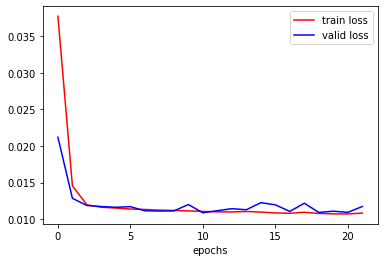

In [ ]:
plt.figure()
plt.plot(train_loss_list, color="r", linestyle="-",label="train loss")
plt.plot(test_loss_list, color="b", linestyle="-",label="valid loss")
plt.legend(loc=1)
plt.xlabel("epochs")
plt.show()

In [ ]:
url = "/content/drive/My Drive/Colab Notebooks/data/Models/DNN/trained3_956250_46411.pt"
model.load_state_dict(torch.load(url, map_location=("cuda:0" if torch.cuda.is_available() else "cpu")))
print(Test_epoch(valid_loader))

[tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(3), tensor(2), tensor(2), tensor(0), tensor(0), tensor(2), tensor(0), tensor(1), tensor(1), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(1), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(0), tensor(1), tensor(2), tensor(2), tensor(1), tensor(1), tensor(2), tensor(2), tensor(0), tensor(0), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2), tensor(2)